#### Import libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the data set

In [2]:
train = np.genfromtxt ('letters.csv', delimiter=",")

In [3]:
n, m = train.shape

In [4]:
print(n, m)

7744 7000


#### Normalise data

In [5]:
def normalise_data(data, axis):
    l2_norm = np.linalg.norm(data, ord=2, axis=axis, keepdims=True) #L2 norm
    norm_data = np.divide(data, l2_norm, where=l2_norm!=0) #normalise where norm!=0
    return norm_data

In [6]:
norm_data = normalise_data(train, 0)

All samples have L2 norm of 1 after normalisation

In [7]:
np.linalg.norm(norm_data, ord=2, axis=0, keepdims=True)[:10] 

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.]])

#### Display a letter

In [ ]:
def show_letter(x, data):
    """ Displays a letter from the dataset given an index
    x - index of the vector in the data
    data - letters dataset
    """
    vec = train[:,x]                                      # get vector at index x
    vec_size = vec.size                                   # size of the letter vector
    img_size = int(math.sqrt(vec_size))                   # size for a 2D image
    img = np.reshape(vec,(img_size, img_size), order="F") # resize the vector
    plt.imshow(img, interpolation = 'nearest', cmap='inferno')

Display a random letter from the training set

In [ ]:
x = np.random.randint(m) # choose random index from training set
show_letter(x, norm_data)

#### Initialise hyperparameters

In [39]:
[n,m]  = np.shape(train)                    # number of pixels and number of training data
eta = 0.01                                  # learning rate
eta_init = 0.05
leaky_eta = eta / 100
winit  = 1                                  # parameter controlling magnitude of initial conditions
alpha = 0.999
epochs = 8
digits = 20                                 # number of prototypes

In [52]:
counter = np.zeros((1,digits))              # counter for the winner neurons
wCount = np.ones(epochs*m) * 0.25           # running avg of the weight change over time

In [13]:
def init_weights_from_data(data, digits):
    n, m = data.shape
    idx = np.random.randint(0, m, digits)
    W = data[:, idx].T
    return W

In [54]:
def init_random_weights(n, digits, winit):
    W = np.random.rand(digits,n) * winit
    return normalise_data(W, 1)

Initialisation using random samples from training data

In [47]:
W = init_weights_from_data(norm_data, digits)

Initalisation using random weights

In [55]:
W = init_random_weights(n, digits, winit)

Make sure the random weights are normalised i.e. L2 norm = 1

In [15]:
np.linalg.norm(W, ord=2, axis=1, keepdims=True)

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

#### Prototypes before training

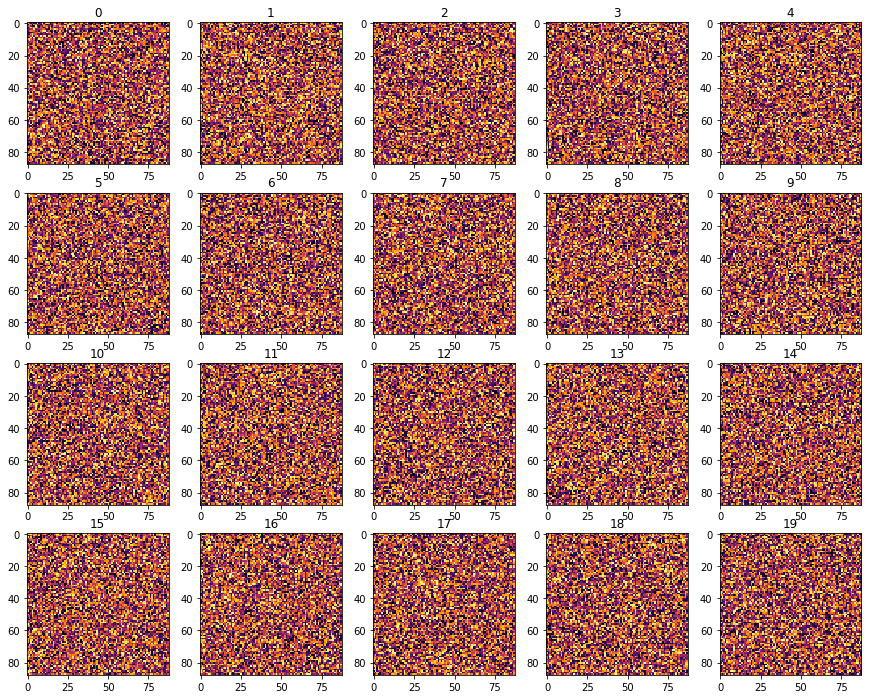

In [56]:
fig, axs = plt.subplots(4, 5, figsize=(15,12))
for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(W[index,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='inferno')
        axs[i, j].set_title(str(index))

#### Training

1) Training loop - setting a maximum number of iterations and select a random input vector from the training data in each iteration

In [53]:
tmax = 40000                                # maximum number of iterations
counter = np.zeros((1,digits))              # counter for the winner neurons
wCount = np.ones((1,tmax+1)) * 0.25         # running avg of the weight change over time

In [54]:
for t in range(1,tmax):
    i = math.ceil(m * np.random.rand())-1   # get a randomly generated index in the input range
    x = norm_data[:,i]                      # pick a training instance using the random index

    h = W.dot(x)/digits                     # get output firing
    h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

    output = np.max(h)                      # get the max in the output firing vector
    k = np.argmax(h)                        # get the index of the firing neuron

    counter[0,k] += 1                       # increment counter for winner neuron
    noise = np.random.normal(0, 0.005, W[k,:].shape)
    noisy_output = W[k,:] + noise           # add noise to the output
    dw = eta * (x.T - noisy_output)         # calculate the change in weights for the k-th output neuron
                                            # get closer to the input (x - W)

    wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # % weight change over time (running avg)

    W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

2) Training loop - updating only the winning neuron

In [57]:
for b in range(epochs):
    idx = np.arange(m)
    np.random.shuffle(idx)
    eta = eta_init * np.exp(-0.01*b)
    for i in range(m):
        
        x = norm_data[:,idx[i]]                 # pick the next training instance in the training data

        h = W.dot(x)/digits                     # get output firing
        h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

        output = np.max(h)                      # get the max in the output firing vector
        k = np.argmax(h)                        # get the index of the firing neuron
        counter[0,k] += 1                       # increment counter for winner neuron
        noise = np.random.normal(0, 0.001, W[k,:].shape)
        noisy_output = W[k,:] + noise           # add noise to the output
        dw = eta * (x.T - noisy_output)         # calculate the change in weights for the k-th output neuron
                                                # get closer to the input (x - W)
        wCount[b*m+i] = wCount[b*m+i-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # weight change over time (running avg)

        W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

Training loop - using leaky learning

In [269]:
for b in range(epochs):
    idx = np.arange(m)
    np.random.shuffle(idx)
    for i in range(m):
        x = norm_data[:,idx[i]]                 # pick the next training instance in the training data

        h = W.dot(x)/digits                     # get output firing
        h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

        output = np.max(h)                      # get the max in the output firing vector
        k = np.argmax(h)                        # get the index of the firing neuron
        counter[0,k] += 1                       # increment counter for winner neuron
        noise = np.random.normal(0, 0.005, W[k,:].shape)
        noisy_output = W[k,:] + noise
        dw = eta * (x.T - noisy_output)         # calculate the change in weights for the k-th output neuron
                                                # get closer to the input (x - W)
        leaky_dw = leaky_eta * (x.T - noisy_output)
        wCount[b*m+i] = wCount[b*m+i-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # weight change over time (running avg)

        W[k,:] = W[k,:] + dw                    # weights for k-th output are updated
        W[(np.arange(digits) != k), :] = W[(np.arange(digits) != k), :] + leaky_dw # weights for the loser neurons
                                                                                   # are updated

#### Prototypes after training

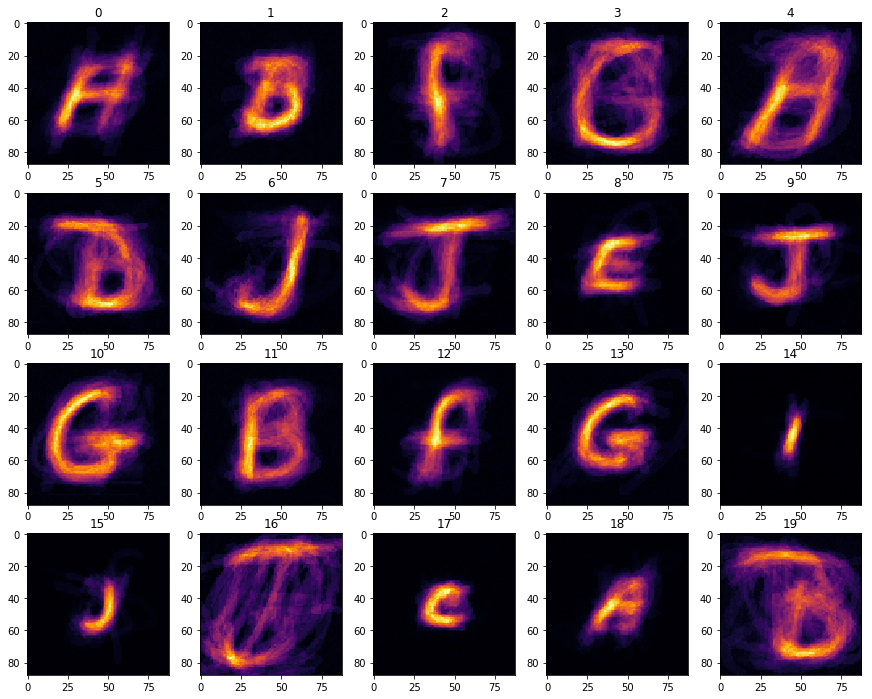

In [58]:
fig, axs = plt.subplots(4, 5, figsize=(15,12))
for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(W[index,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='inferno')
        axs[i, j].set_title(str(index))

#### Distribution of winning neurons

In [297]:
threshold = 1 / counter.size / 20
print(counter < threshold)

[[False False False False False False False False False False False False
  False False False False False False False False]]


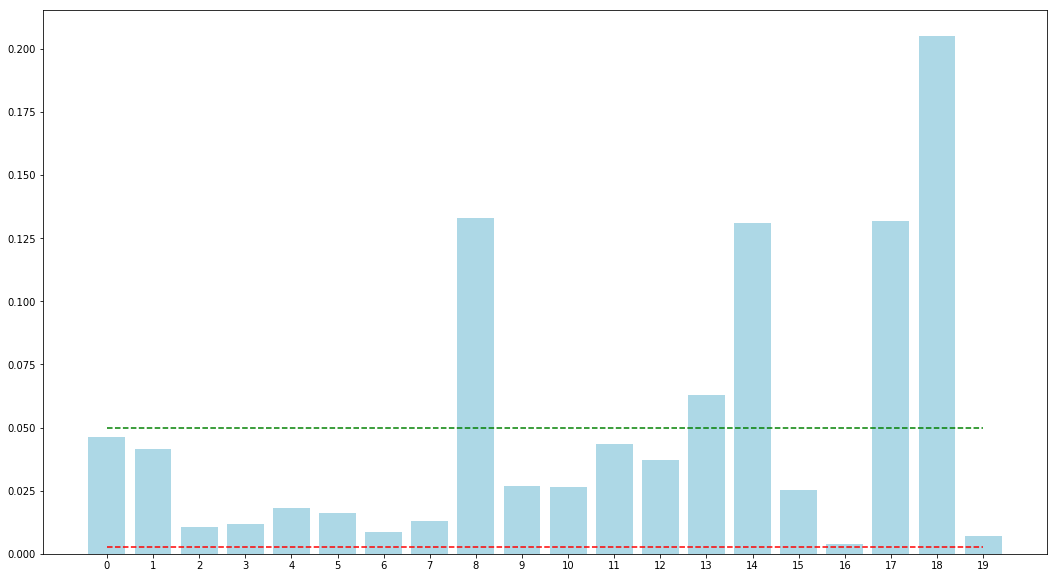

In [59]:
plt.figure(figsize=(18,10))
plt.bar(np.arange(counter.size) , counter[0,:]/ counter.sum(), color='lightblue')
plt.xticks(np.arange(counter.size))
plt.plot(np.arange(counter.size), (np.ones(counter.size)/counter.size), color='g', linestyle='--')
plt.plot(np.arange(counter.size), (np.ones(counter.size)/counter.size/20), color='r', linestyle='--')
plt.show()

#### Weight change over time

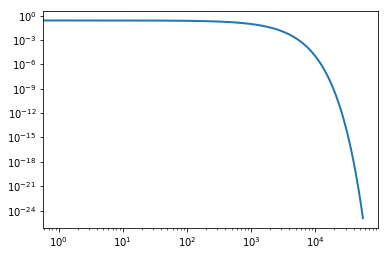

In [23]:
# Plot running average
plt.loglog(wCount[0:epochs*m], linewidth=2.0, label='rate')

#### Correlation between prototypes

In [331]:
corr = np.corrcoef(W)

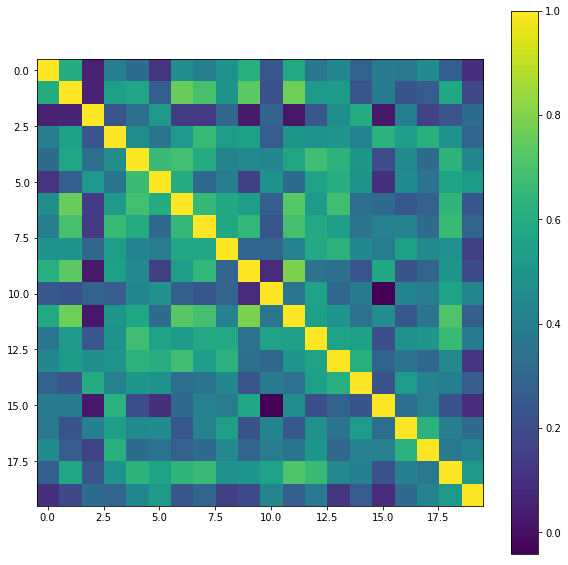

In [332]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(counter.size))
plt.imshow(corr)

plt.colorbar()

#### Highly correlated prototypes

Print the pairs of prototypes that are highly correlated

In [333]:
high_corr = corr > 0.70
a, _ = high_corr.shape
for i in range(a - 1):
    for j in range(i+1, a):
        if(high_corr[i, j]):
            print(i, j)

1 6
1 9
1 11
6 11
9 11
11 18
